In [169]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [170]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from utils import load_data

In [172]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


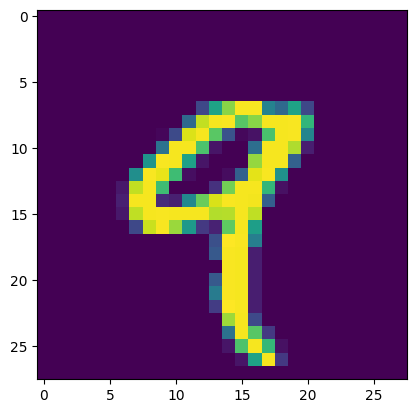

In [173]:
plt.imshow(train_input[4].view((28,28)))

In [174]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [175]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [176]:
# The functions should have no python loop, and use in particular torch.tanh, torch.exp, torch.mul, and torch.pow
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(sigma(x), 2)

In [177]:
def loss (v,t):
    return (v - t).pow(2).sum()

def dloss(v,t):
    return 2 * (v - t)

In [178]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 2.2774,  0.8057,  1.0494,  3.4660,  0.1409,  1.9316],
        [-5.3371,  2.9470,  0.9686, -0.6732,  2.0610,  2.2667],
        [-1.3861, -4.2525,  0.6948,  5.4074, -1.3290,  1.5755]])

In [179]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [180]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [219]:
torch.manual_seed(1337)
epsilon = 1e-6
w1 = torch.empty((50, 784)).normal_(0, epsilon) # 50 neurons, 784 inputs
b1 = torch.empty(50).normal_(0, epsilon) # 50 neurons
w2 = torch.empty((10, 50)).normal_(0, epsilon) # 10 outputs, 50 neurons
b2 = torch.empty(10).normal_(0, epsilon) # 10 outputs
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [223]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1.t() + b1
h1 = sigma(z1)
z2 = h1 @ w2.t() + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(4.0500, grad_fn=<SumBackward0>))

In [224]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=4.049995422363281


In [232]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1)
cmp('h2',dh2,h2) # should return True
dz2 = dh2 * dsigma(z2)  # chain rule
cmp('z2',dz2, z2)
dw2 = dz2.t() @ h1
cmp('w2',dw2, w2)
db2 = dz2.sum(dim=0)
cmp('b2',db2, b2)
dh1 = dz2 @ w2
cmp('h1',dh1, h1)
dz1 = dh1 * dsigma(z1) 
cmp('z1', dz1, z1)
dw1 = dz1.t() @ x1
cmp('w1', dw1, w1)
db1 = dz1.sum(dim=0)
cmp('b1', db1, b1)

h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [233]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1
    w2 += -lr * dw2
    b2 += -lr * db2

In [234]:
l = loss(h2, y1)
l.item()

4.049995422363281

##### Now that we've checked our gradients are correct, we can implement the network

In [374]:
def forward(w1, b1, w2, b2, x):
    x1 = x @ w1.t() + b1
    h1 = sigma(x1)
    x2 = h1 @ w2.t() + b2
    h2 = sigma(x2)
    return x1, h1, x2, h2


In [362]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1)
    dz2 = dh2 * dsigma(z2)
    dw2 = dz2.t() @ h1
    db2 = dz2.sum(dim=0)
    dh1 = dz2 @ w2
    dz1 = dh1 * dsigma(z1) 
    dw1 = dz1.t() @ x1
    db1 = dz1.sum(dim=0)
    #print(w1.shape, dw1.shape)
    return dw1, db1, dw2, db2

In [363]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        #print(w1.shape, dw1.shape)
        w1 += -lr * dw1
        b1 += -lr * db1
        w2 += -lr * dw2
        b2 += -lr * db2
    return w1, b1, w2, b2

In [364]:
def init():
    """ init a network """
    w1 = torch.empty((50, 784)).normal_(0, epsilon) # 50 neurons, 784 inputs
    b1 = torch.empty(50).normal_(0, epsilon) # 50 neurons
    w2 = torch.empty((10, 50)).normal_(0, epsilon) # 10 outputs, 50 neurons
    b2 = torch.empty(10).normal_(0, epsilon) # 10 outputs
    return w1, b1, w2, b2

In [365]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [368]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        x1, h1, x2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward                   
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, x1, yb, h2, z2, h1, z1)
        print(w1.shape, dw1.shape)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi


In [375]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 809.9996948242188
step = 100, loss = 354.7684326171875
step = 200, loss = 197.4700164794922
step = 300, loss = 140.02499389648438
step = 400, loss = 133.54147338867188
step = 500, loss = 90.13886260986328
step = 600, loss = 83.04899597167969
step = 700, loss = 71.0525131225586
step = 800, loss = 58.850067138671875
step = 900, loss = 55.92335510253906
step = 1000, loss = 64.59211730957031
step = 1100, loss = 44.270347595214844
step = 1200, loss = 57.44610595703125
step = 1300, loss = 46.97384262084961
step = 1400, loss = 44.86290740966797
step = 1500, loss = 38.646968841552734
step = 1600, loss = 35.984458923339844
step = 1700, loss = 35.084529876708984
step = 1800, loss = 32.5633544921875
step = 1900, loss = 42.53522491455078
step = 2000, loss = 31.626054763793945
step = 2100, loss = 29.459714889526367
step = 2200, loss = 24.623220443725586
step = 2300, loss = 25.00797462463379
step = 2400, loss = 22.848424911499023
step = 2500, loss = 27.087385177612305
step = 2600, l

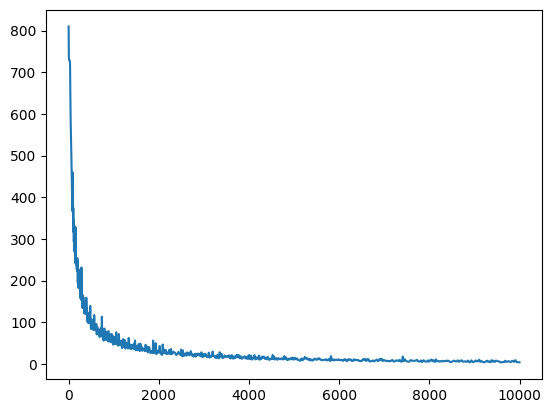

In [376]:
plt.plot(lossi)
#print(lossi)

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [377]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [378]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [379]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [380]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 809.9999389648438
step = 100, loss = 376.9007568359375
step = 200, loss = 232.30006408691406
step = 300, loss = 146.78643798828125
step = 400, loss = 105.31110382080078
step = 500, loss = 109.19357299804688
step = 600, loss = 77.50238800048828
step = 700, loss = 67.4498519897461
step = 800, loss = 56.967613220214844
step = 900, loss = 50.97842025756836
step = 1000, loss = 42.40766143798828
step = 1100, loss = 44.74934005737305
step = 1200, loss = 34.07716369628906
step = 1300, loss = 42.0624885559082
step = 1400, loss = 43.334293365478516
step = 1500, loss = 35.15777587890625
step = 1600, loss = 31.19450569152832
step = 1700, loss = 42.97434997558594
step = 1800, loss = 25.806554794311523
step = 1900, loss = 22.062623977661133
step = 2000, loss = 30.207263946533203
step = 2100, loss = 19.052846908569336
step = 2200, loss = 28.467117309570312
step = 2300, loss = 22.306114196777344
step = 2400, loss = 21.412532806396484
step = 2500, loss = 22.788036346435547
step = 2600,

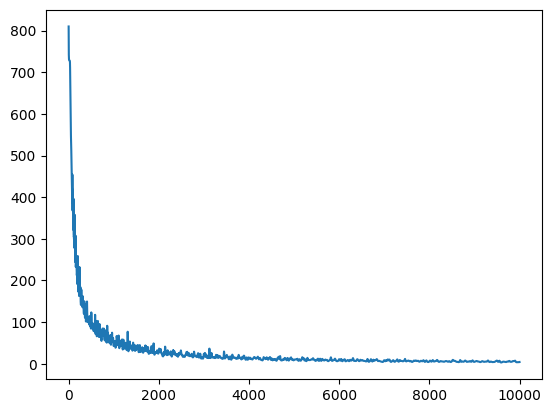

In [381]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [382]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [383]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [384]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [329]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')




step =      0	loss=0.14783	accuracy (train, test): 0.06200	0.25100
step =   1000	loss=0.00011	accuracy (train, test): 1.00000	0.88000
step =   2000	loss=0.00019	accuracy (train, test): 1.00000	0.87800
step =   3000	loss=0.00002	accuracy (train, test): 1.00000	0.87800
step =   4000	loss=0.00003	accuracy (train, test): 1.00000	0.88100
step =   5000	loss=0.00007	accuracy (train, test): 1.00000	0.88300
step =   6000	loss=0.00029	accuracy (train, test): 1.00000	0.87600
step =   7000	loss=0.00003	accuracy (train, test): 1.00000	0.87200
step =   8000	loss=0.00003	accuracy (train, test): 1.00000	0.87000
step =   9000	loss=0.00007	accuracy (train, test): 1.00000	0.87300


##### Exercise: try to improve accuracy!

In [390]:
# we now try to improve the accuracy of the model using several techniques seen in the lecture:

# - we use a batch normalization layer
# - we use a different optimizer (Adam)
# - we use a different activation function (ReLU)
# - we use a different weight initialization scheme (He)
# - we add a dropout layer

class MLP_improved(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.BatchNorm1d(n_hidden), # batch normalization
            nn.ReLU(),
            nn.Dropout(0.2), # 20% dropout
            nn.Linear(n_hidden, n_out),
            nn.BatchNorm1d(n_out), # batch normalization
            nn.ReLU()
            ))
        # weight initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu') # He initialization
                nn.init.zeros_(layer.bias) # set bias to zero

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

model = MLP_improved()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [391]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')

step =      0	loss=0.51303	accuracy (train, test): 0.13300	0.19300
step =   1000	loss=0.00149	accuracy (train, test): 0.99600	0.81500
step =   2000	loss=0.00085	accuracy (train, test): 0.99600	0.82100
step =   3000	loss=0.00059	accuracy (train, test): 0.99600	0.82100
step =   4000	loss=0.00039	accuracy (train, test): 0.99700	0.83300
step =   5000	loss=0.00035	accuracy (train, test): 0.99700	0.82700
step =   6000	loss=0.00060	accuracy (train, test): 0.99700	0.82500
step =   7000	loss=0.00028	accuracy (train, test): 0.99700	0.82300
step =   8000	loss=0.00032	accuracy (train, test): 0.99700	0.81400
step =   9000	loss=0.00029	accuracy (train, test): 0.99700	0.81200


In [392]:
# I observe that the accuracy is not much better than with the previous model. This is because the dataset is simple and the model is already quite good.
# Moreover, the dropout and regularization techniques do not help improving the accuracy in this case, they are more useful when the model is overfitting.